# Traffic Sign Detection - Data Exploration

This notebook explores the traffic sign dataset from Roboflow.

**Colab Setup**: This notebook is designed to run on Google Colab with GPU support.

## 1. Setup Environment

In [1]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    # Clone repository
    !git clone https://github.com/YOUR_USERNAME/traffic-sign-detection.git
    %cd traffic-sign-detection
else:
    print("Running locally")
    import os
    if os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')

Running locally


In [ ]:
# Install dependencies
!pip install -q roboflow opencv-python matplotlib seaborn pandas plotly tqdm

In [2]:
# Import libraries
import sys
sys.path.append('src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from pathlib import Path
import json
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Download Dataset from Roboflow

In [4]:
from src.utils.roboflow_loader import RoboflowDataLoader

# Initialize loader with your credentials
loader = RoboflowDataLoader(
    api_key="gbb6oBUEJlstBEF0CruH",
    workspace="giaothong-t5tdy",
    project="phat_hien_bien_bao-zsswb",
    version=1
)

# Download in YOLOv8 format
dataset_path = loader.download_dataset(format="yolov8")
print(f"Dataset downloaded to: {dataset_path}")

loading Roboflow workspace...
loading Roboflow project...
Workspace: giaothong-t5tdy
Project: phat_hien_bien_bao-zsswb
Version: 1



Extracting Dataset Version Zip to data/raw/yolov8 in yolov8:: 100%|██████████| 3078/3078 [00:00<00:00, 12975.67it/s]

Dataset downloaded successfully to: /Users/kietnt/Desktop/Workspace/traffic-sign-detection/data/raw/yolov8
Dataset info saved to: data/raw/dataset_info_yolov8.json
Dataset downloaded to: /Users/kietnt/Desktop/Workspace/traffic-sign-detection/data/raw/yolov8


In [5]:
# Get dataset information
dataset_info = loader.get_dataset_info()

print("="*50)
print("DATASET INFORMATION")
print("="*50)
print(f"Number of classes: {dataset_info['num_classes']}")
print(f"\nClass names:")
for idx, name in enumerate(dataset_info['class_names']):
    print(f"  {idx}: {name}")
print(f"\nData splits:")
print(f"  Train: {dataset_info['train_path']}")
print(f"  Val: {dataset_info['val_path']}")
print(f"  Test: {dataset_info['test_path']}")

DATASET INFORMATION
Number of classes: 5

Class names:
  0: bien_bao_cam
  1: bien_bao_hieu_lenh
  2: bien_bao_nguy_hiem_va_canh_bao
  3: bien_chi_dan
  4: bien_phu

Data splits:
  Train: ../train/images
  Val: ../valid/images
  Test: ../test/images


## 3. Dataset Statistics

In [6]:
from pathlib import Path

# Count images in each split
data_root = Path(dataset_path)

train_images = list((data_root / 'train' / 'images').glob('*.*'))
val_images = list((data_root / 'valid' / 'images').glob('*.*'))
test_images = list((data_root / 'test' / 'images').glob('*.*'))

print("Dataset Split Statistics:")
print(f"  Training images: {len(train_images)}")
print(f"  Validation images: {len(val_images)}")
print(f"  Test images: {len(test_images)}")
print(f"  Total images: {len(train_images) + len(val_images) + len(test_images)}")

Dataset Split Statistics:
  Training images: 1062
  Validation images: 165
  Test images: 306
  Total images: 1533


In [7]:
# Analyze class distribution
def count_classes_in_split(labels_dir, num_classes):
    """Count instances of each class in a split"""
    class_counts = Counter()
    
    for label_file in Path(labels_dir).glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    
    return class_counts

# Count classes in each split
train_class_counts = count_classes_in_split(data_root / 'train' / 'labels', dataset_info['num_classes'])
val_class_counts = count_classes_in_split(data_root / 'valid' / 'labels', dataset_info['num_classes'])
test_class_counts = count_classes_in_split(data_root / 'test' / 'labels', dataset_info['num_classes'])

print("\nClass Distribution:")
print(f"{'Class':<30} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
print("="*70)

for class_id in range(dataset_info['num_classes']):
    class_name = dataset_info['class_names'][class_id]
    train_count = train_class_counts.get(class_id, 0)
    val_count = val_class_counts.get(class_id, 0)
    test_count = test_class_counts.get(class_id, 0)
    total = train_count + val_count + test_count
    
    print(f"{class_name:<30} {train_count:<10} {val_count:<10} {test_count:<10} {total:<10}")


Class Distribution:
Class                          Train      Val        Test       Total     
bien_bao_cam                   642        95         195        932       
bien_bao_hieu_lenh             142        12         42         196       
bien_bao_nguy_hiem_va_canh_bao 355        63         111        529       
bien_chi_dan                   253        37         55         345       
bien_phu                       167        32         52         251       


## 4. Visualize Class Distribution

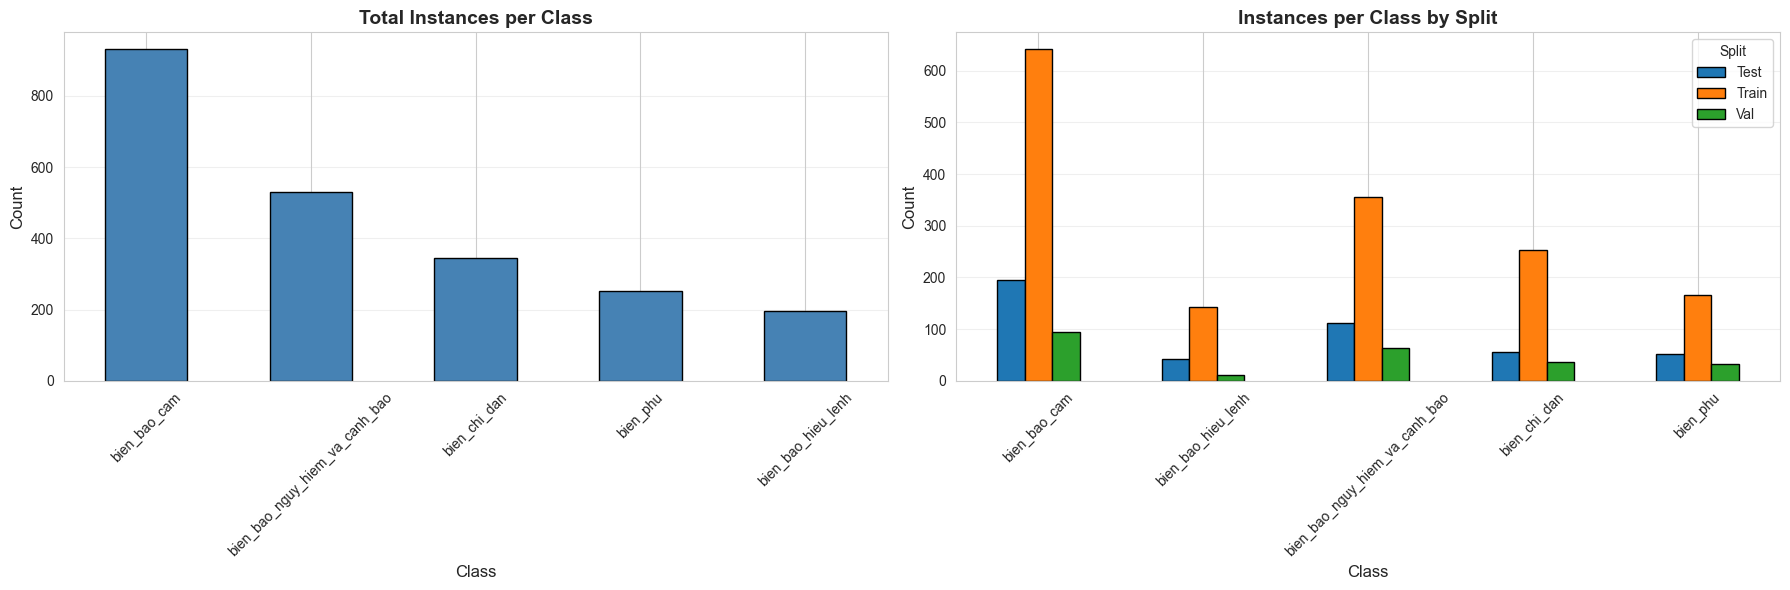

In [8]:
# Create class distribution dataframe
class_data = []

for class_id in range(dataset_info['num_classes']):
    class_name = dataset_info['class_names'][class_id]
    
    class_data.append({
        'Class': class_name,
        'Split': 'Train',
        'Count': train_class_counts.get(class_id, 0)
    })
    class_data.append({
        'Class': class_name,
        'Split': 'Val',
        'Count': val_class_counts.get(class_id, 0)
    })
    class_data.append({
        'Class': class_name,
        'Split': 'Test',
        'Count': test_class_counts.get(class_id, 0)
    })

df_classes = pd.DataFrame(class_data)

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Total per class
total_per_class = df_classes.groupby('Class')['Count'].sum().sort_values(ascending=False)
total_per_class.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Total Instances per Class', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Per split
df_pivot = df_classes.pivot(index='Class', columns='Split', values='Count')
df_pivot.plot(kind='bar', ax=ax2, edgecolor='black')
ax2.set_title('Instances per Class by Split', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Split')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Analyze Image Properties

In [9]:
# Sample images to analyze (to avoid processing all)
sample_size = min(500, len(train_images))
sampled_images = np.random.choice(train_images, sample_size, replace=False)

image_stats = []

for img_path in tqdm(sampled_images, desc="Analyzing images"):
    img = cv2.imread(str(img_path))
    if img is not None:
        h, w = img.shape[:2]
        aspect_ratio = w / h
        
        image_stats.append({
            'width': w,
            'height': h,
            'aspect_ratio': aspect_ratio,
            'area': w * h
        })

df_images = pd.DataFrame(image_stats)

print("\nImage Statistics:")
print(df_images.describe())

Analyzing images: 100%|██████████| 500/500 [00:00<00:00, 1140.01it/s]


Image Statistics:
       width  height  aspect_ratio      area
count  500.0   500.0         500.0     500.0
mean   640.0   640.0           1.0  409600.0
std      0.0     0.0           0.0       0.0
min    640.0   640.0           1.0  409600.0
25%    640.0   640.0           1.0  409600.0
50%    640.0   640.0           1.0  409600.0
75%    640.0   640.0           1.0  409600.0
max    640.0   640.0           1.0  409600.0


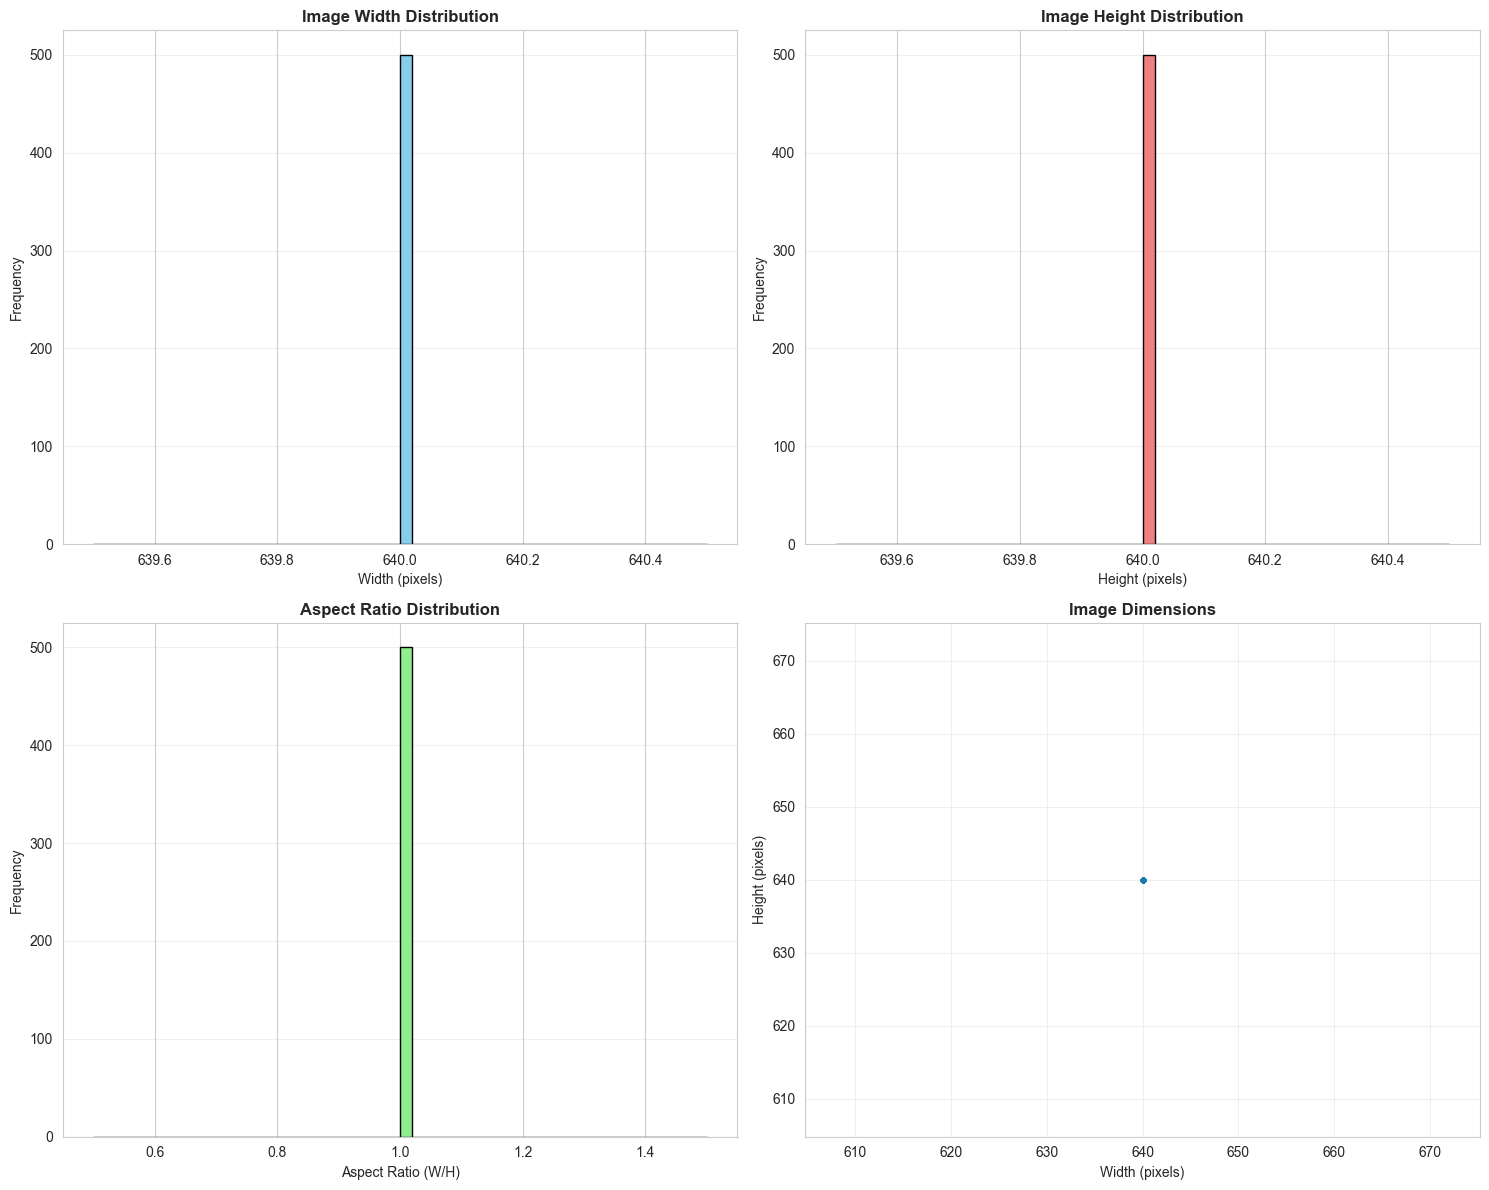

In [10]:
# Visualize image properties
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(df_images['width'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# Height distribution
axes[0, 1].hist(df_images['height'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(df_images['aspect_ratio'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

# Width vs Height scatter
axes[1, 1].scatter(df_images['width'], df_images['height'], alpha=0.5, s=10)
axes[1, 1].set_title('Image Dimensions', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize Sample Images with Annotations

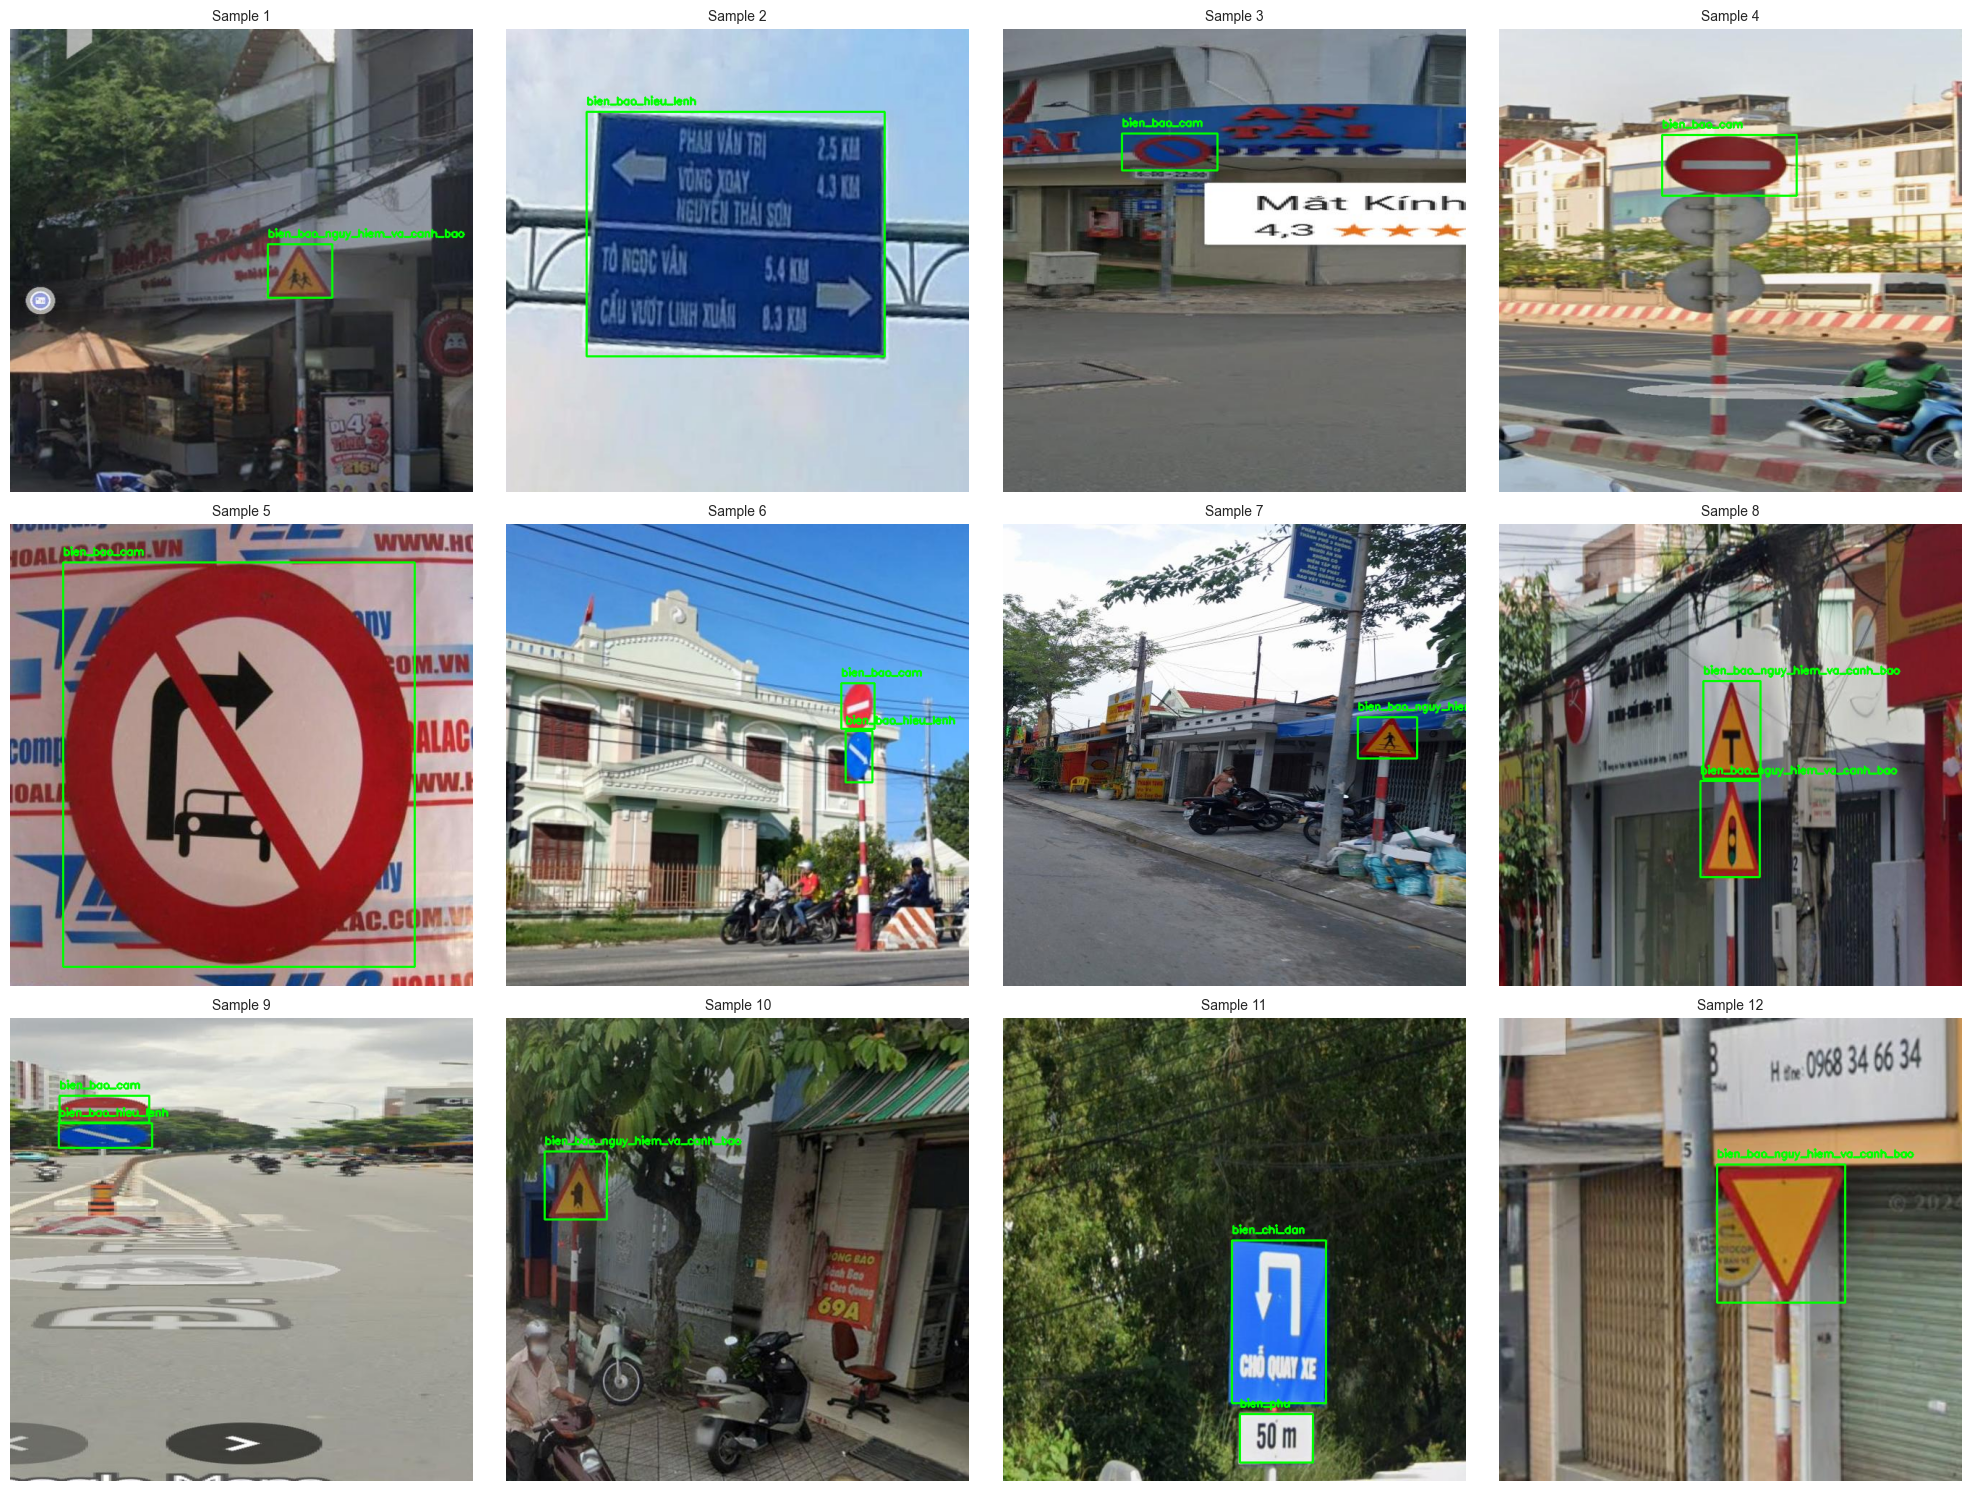

In [11]:
def draw_yolo_boxes(image, label_file, class_names):
    """Draw YOLO format bounding boxes on image"""
    h, w = image.shape[:2]
    result = image.copy()
    
    if not label_file.exists():
        return result
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:5])
            
            # Convert to pixel coordinates
            x1 = int((cx - bw/2) * w)
            y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w)
            y2 = int((cy + bh/2) * h)
            
            # Draw box
            cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Draw label
            label = class_names[class_id]
            cv2.putText(result, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return result

# Sample and visualize images
n_samples = 12
sample_images = np.random.choice(train_images, n_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get corresponding label file
    label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
    
    # Draw boxes
    img_with_boxes = draw_yolo_boxes(img, label_path, dataset_info['class_names'])
    
    # Display
    axes[idx].imshow(img_with_boxes)
    axes[idx].set_title(f"Sample {idx+1}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 7. Analyze Bounding Box Properties

In [12]:
# Analyze bounding box sizes
bbox_stats = []

label_files = list((data_root / 'train' / 'labels').glob('*.txt'))[:500]  # Sample for speed

for label_file in tqdm(label_files, desc="Analyzing bboxes"):
    # Get image dimensions
    img_file = label_file.parent.parent / 'images' / f"{label_file.stem}{train_images[0].suffix}"
    img = cv2.imread(str(img_file))
    if img is None:
        continue
    
    h, w = img.shape[:2]
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, bw, bh = map(float, parts[1:5])
            
            bbox_stats.append({
                'class_id': class_id,
                'class_name': dataset_info['class_names'][class_id],
                'width': bw * w,
                'height': bh * h,
                'area': bw * bh * w * h,
                'aspect_ratio': bw / bh if bh > 0 else 0
            })

df_bbox = pd.DataFrame(bbox_stats)

print("\nBounding Box Statistics:")
print(df_bbox.describe())

Analyzing bboxes: 100%|██████████| 500/500 [00:00<00:00, 1195.60it/s]


Bounding Box Statistics:
         class_id       width      height           area  aspect_ratio
count  711.000000  711.000000  711.000000     711.000000    711.000000
mean     1.483826  135.139241  130.834037   26350.582982      1.271413
std      1.412003  111.752183  112.357731   50303.804933      0.951590
min      0.000000    7.500000    6.000000      45.000000      0.236601
25%      0.000000   64.750000   57.000000    4419.250000      0.637874
50%      2.000000  101.000000   95.500000    9741.000000      0.924731
75%      3.000000  163.250000  155.750000   20721.500000      1.622702
max      4.000000  640.000000  636.000000  406720.000000      7.719298


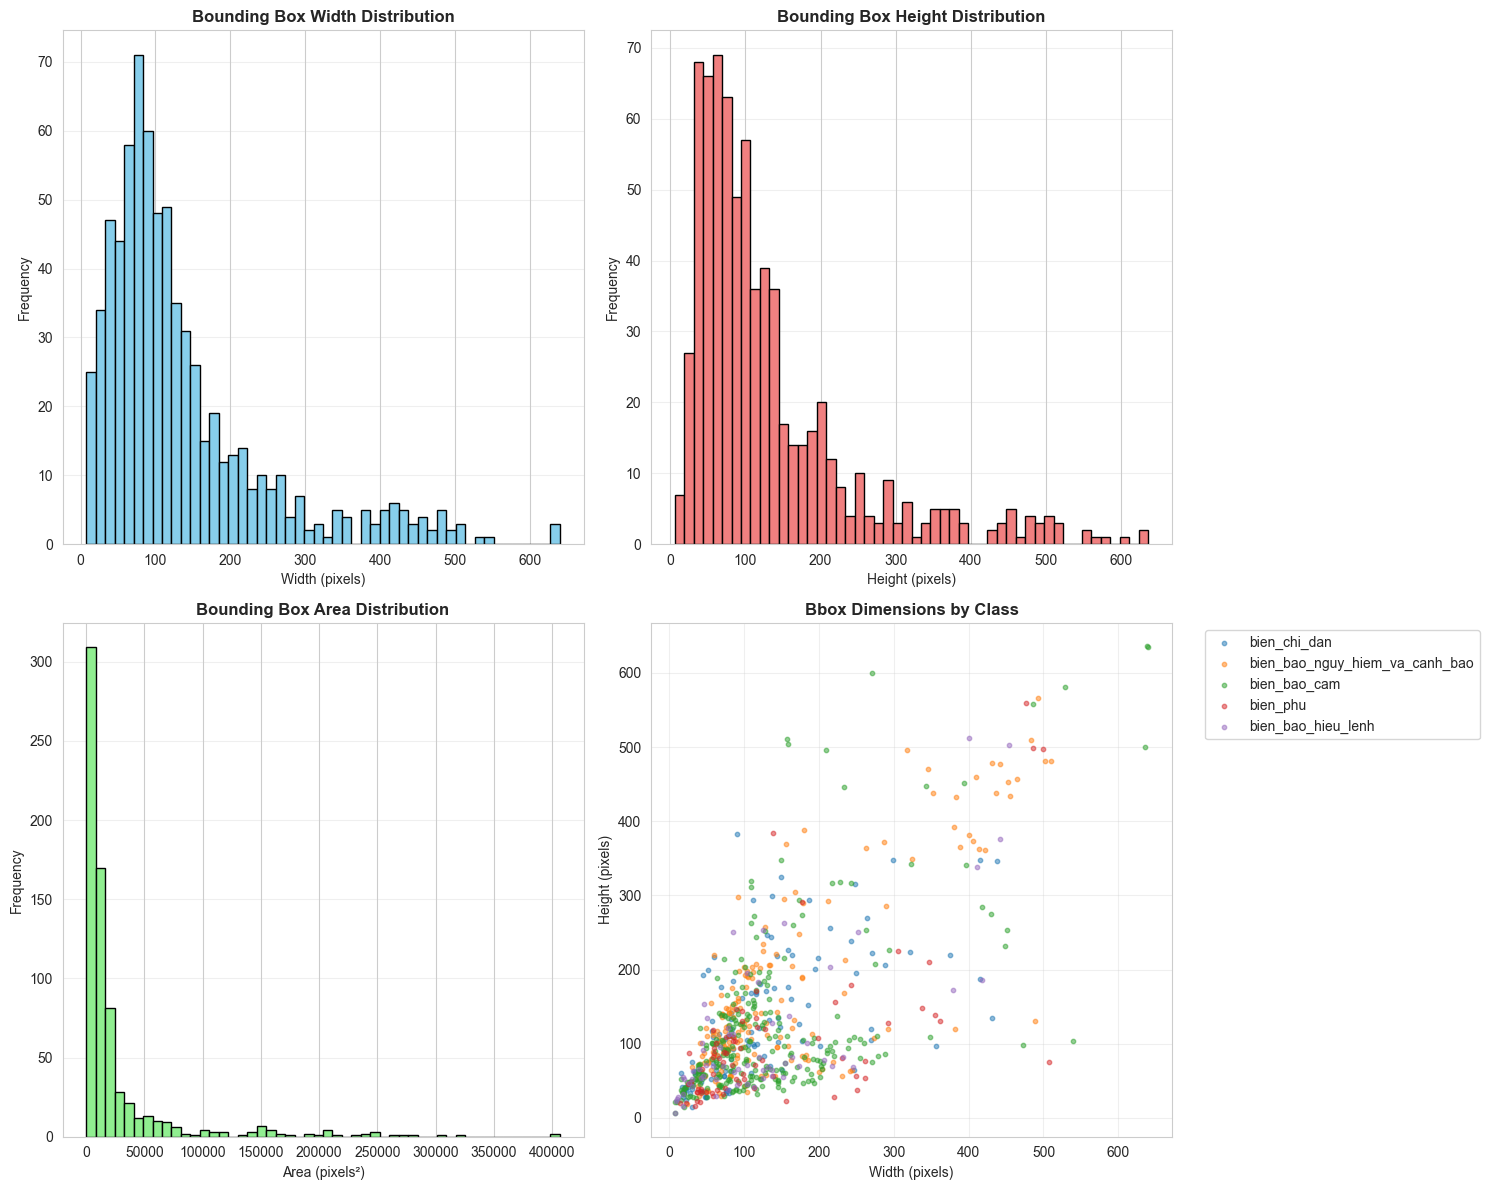

In [13]:
# Visualize bbox properties
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bbox width distribution
axes[0, 0].hist(df_bbox['width'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Bounding Box Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# Bbox height distribution
axes[0, 1].hist(df_bbox['height'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Bounding Box Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# Bbox area distribution
axes[1, 0].hist(df_bbox['area'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Bounding Box Area Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Area (pixels²)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(axis='y', alpha=0.3)

# Width vs Height scatter by class
for class_name in df_bbox['class_name'].unique():
    class_data = df_bbox[df_bbox['class_name'] == class_name]
    axes[1, 1].scatter(class_data['width'], class_data['height'], 
                      label=class_name, alpha=0.5, s=10)

axes[1, 1].set_title('Bbox Dimensions by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Recommendations

In [14]:
print("="*70)
print("DATASET SUMMARY & RECOMMENDATIONS")
print("="*70)

print(f"\n1. Dataset Size:")
print(f"   - Total images: {len(train_images) + len(val_images) + len(test_images)}")
print(f"   - Total annotations: {sum(train_class_counts.values()) + sum(val_class_counts.values()) + sum(test_class_counts.values())}")

print(f"\n2. Class Balance:")
class_totals = {}
for class_id in range(dataset_info['num_classes']):
    total = (train_class_counts.get(class_id, 0) + 
             val_class_counts.get(class_id, 0) + 
             test_class_counts.get(class_id, 0))
    class_totals[dataset_info['class_names'][class_id]] = total

max_count = max(class_totals.values())
min_count = min(class_totals.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"   - Most common class: {max(class_totals, key=class_totals.get)} ({max_count} instances)")
print(f"   - Least common class: {min(class_totals, key=class_totals.get)} ({min_count} instances)")
print(f"   - Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("   ⚠ WARNING: Significant class imbalance detected!")
    print("   → Consider: Data augmentation, weighted loss, or oversampling")

print(f"\n3. Image Properties:")
print(f"   - Mean dimensions: {df_images['width'].mean():.0f} x {df_images['height'].mean():.0f}")
print(f"   - Recommended input size: 640x640 (standard for YOLO)")

print(f"\n4. Bounding Box Properties:")
print(f"   - Mean bbox size: {df_bbox['width'].mean():.0f} x {df_bbox['height'].mean():.0f}")
print(f"   - Min bbox area: {df_bbox['area'].min():.0f} pixels²")
if df_bbox['area'].min() < 32*32:
    print("   ⚠ Very small objects detected - may be challenging to detect")
    print("   → Consider: Multi-scale training, higher resolution, or feature pyramid")

print(f"\n5. Recommended Training Strategies:")
print("   - Start with YOLOv11n for fast baseline")
print("   - Use data augmentation (especially for imbalanced classes)")
print("   - Train for at least 100 epochs with early stopping")
print("   - Use cosine learning rate schedule")
print("   - Monitor mAP@0.5 and mAP@0.5:0.95")

print("\n" + "="*70)

DATASET SUMMARY & RECOMMENDATIONS

1. Dataset Size:
   - Total images: 1533
   - Total annotations: 2253

2. Class Balance:
   - Most common class: bien_bao_cam (932 instances)
   - Least common class: bien_bao_hieu_lenh (196 instances)
   - Imbalance ratio: 4.76
   ⚠ WARNING: Significant class imbalance detected!
   → Consider: Data augmentation, weighted loss, or oversampling

3. Image Properties:
   - Mean dimensions: 640 x 640
   - Recommended input size: 640x640 (standard for YOLO)

4. Bounding Box Properties:
   - Mean bbox size: 135 x 131
   - Min bbox area: 45 pixels²
   ⚠ Very small objects detected - may be challenging to detect
   → Consider: Multi-scale training, higher resolution, or feature pyramid

5. Recommended Training Strategies:
   - Start with YOLOv11n for fast baseline
   - Use data augmentation (especially for imbalanced classes)
   - Train for at least 100 epochs with early stopping
   - Use cosine learning rate schedule
   - Monitor mAP@0.5 and mAP@0.5:0.95



## Next Steps

1. **Traditional Methods**: Run `02_traditional_methods.ipynb` to test HOG+SVM and Color+Shape detectors
2. **Modern Methods**: Run `03_modern_methods.ipynb` to train YOLOv11 and Faster R-CNN
3. **Evaluation**: Compare all methods using the benchmarking framework